In [20]:
# Referencing https://github.com/zcaceres/spec_augment

In [ ]:
from collections import namedtuple
import random
import torch
import torchaudio
from torchaudio import transforms
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

## Convert WAV to Mel Spectrogram

In [27]:
def tensor_to_img(spectrogram):
    plt.figure(figsize=(14,1))
    plt.imshow(spectrogram[0])
    plt.show()
    display(spectrogram.shape)

In [22]:
class SpectrogramToDB(object):
    """Turns a spectrogram from the power/amplitude scale to the decibel scale.
    This output depends on the maximum value in the input spectrogram, and so
    may return different values for an audio clip split into snippets vs. a
    a full clip. This method is sourced from an earlier release of torchaudio and
    is no longer present in current versions.
    Args:
        stype (str): scale of input spectrogram ("power" or "magnitude").  The
            power being the elementwise square of the magnitude. default: "power"
        top_db (float, optional): minimum negative cut-off in decibels.  A reasonable number
            is 80.
    """
    def __init__(self, stype="power", top_db=None):
        self.stype = stype
        if top_db is not None and top_db < 0:
            raise ValueError('top_db must be positive value')
        self.top_db = top_db
        self.multiplier = 10. if stype == "power" else 20.
        self.amin = 1e-10
        self.ref_value = 1.
        self.db_multiplier = np.log10(np.maximum(self.amin, self.ref_value))

    def __call__(self, spec):
        # numerically stable implementation from librosa
        # https://librosa.github.io/librosa/_modules/librosa/core/spectrum.html
        spec_db = self.multiplier * torch.log10(torch.clamp(spec, min=self.amin))
        spec_db -= self.multiplier * self.db_multiplier

        if self.top_db is not None:
            spec_db = torch.max(spec_db, spec_db.new_full((1,), spec_db.max() - self.top_db))
        return spec_db

In [23]:
def tfm_spectro(ad:Audio, sr=16000, to_db_scale=False, n_fft=1024, 
                ws=None, hop=None, f_min=0.0, f_max=-80, pad=0, n_mels=128):
    # We must reshape signal for torchaudio to generate the spectrogram.
    mel = transforms.MelSpectrogram(sample_rate=ad.sr, n_mels=n_mels, n_fft=n_fft, win_length=ws, hop_length=hop, 
                                    f_min=f_min, f_max=f_max, pad=pad,)(ad.sig.reshape(1, -1))
    if to_db_scale: mel = SpectrogramToDB(stype='magnitude', top_db=f_max)(mel)
    return mel

In [24]:
AudioData = namedtuple('AudioData', ['sig', 'sr'])

In [25]:
audio = AudioData(*torchaudio.load("../test.wav"))

/nethome/sramshetty3/anaconda3/lib/python3.8/site-packages/torchaudio/functional/functional.py:357: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


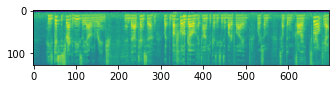

torch.Size([1, 128, 696])

In [30]:
spectrogram = tfm_spectro(audio, ws=512, hop=256, n_mels=128, to_db_scale=True, f_max=8000, f_min=-80)
tensor_to_img(spectrogram)

## Time Warp

In [39]:
# From https://github.com/bobchennan/sparse_image_warp_pytorch/blob/master/sparse_image_warp.py
def sparse_image_warp(img_tensor,
                      source_control_point_locations,
                      dest_control_point_locations,
                      interpolation_order=2,
                      regularization_weight=0.0,
                      num_boundaries_points=0):
    device = img_tensor.device
    control_point_flows = dest_control_point_locations - source_control_point_locations

    batch_size, image_height, image_width = img_tensor.shape
    flattened_grid_locations = get_flat_grid_locations(image_height, image_width, device)

    flattened_flows = interpolate_spline(
        dest_control_point_locations,
        control_point_flows,
        flattened_grid_locations,
        interpolation_order,
        regularization_weight)

    dense_flows = create_dense_flows(flattened_flows, batch_size, image_height, image_width)

    warped_image = dense_image_warp(img_tensor, dense_flows)

    return warped_image, dense_flows


def get_grid_locations(image_height, image_width, device):
    y_range = torch.linspace(0, image_height - 1, image_height, device=device)
    x_range = torch.linspace(0, image_width - 1, image_width, device=device)
    y_grid, x_grid = torch.meshgrid(y_range, x_range)
    return torch.stack((y_grid, x_grid), -1)


def flatten_grid_locations(grid_locations, image_height, image_width):
    return torch.reshape(grid_locations, [image_height * image_width, 2])


def get_flat_grid_locations(image_height, image_width, device):
    y_range = torch.linspace(0, image_height - 1, image_height, device=device)
    x_range = torch.linspace(0, image_width - 1, image_width, device=device)
    y_grid, x_grid = torch.meshgrid(y_range, x_range)
    return torch.stack((y_grid, x_grid), -1).reshape([image_height * image_width, 2])


def create_dense_flows(flattened_flows, batch_size, image_height, image_width):
    # possibly .view
    return torch.reshape(flattened_flows, [batch_size, image_height, image_width, 2])


def interpolate_spline(train_points, train_values, query_points, order, regularization_weight=0.0,):
    # First, fit the spline to the observed data.
    w, v = solve_interpolation(train_points, train_values, order, regularization_weight)
    # Then, evaluate the spline at the query locations.
    query_values = apply_interpolation(query_points, train_points, w, v, order)

    return query_values


def solve_interpolation(train_points, train_values, order, regularization_weight):
    device = train_points.device
    b, n, d = train_points.shape
    k = train_values.shape[-1]

    c = train_points
    f = train_values.float()

    matrix_a = phi(cross_squared_distance_matrix(c, c), order)  # [b, n, n]

    # Append ones to the feature values for the bias term in the linear model.
    #ones = torch.ones(1, dtype=train_points.dtype, device=device).view([-1, 1, 1])
    ones = torch.ones_like(c[:, :, :1], dtype=train_points.dtype, device=device)
    matrix_b = torch.cat((c, ones), 2).float()  # [b, n, d + 1]

    # [b, n + d + 1, n]
    left_block = torch.cat((matrix_a, torch.transpose(matrix_b, 2, 1)), 1)

    num_b_cols = matrix_b.shape[2]  # d + 1

    # In Tensorflow, zeros are used here. Pytorch solve fails with zeros for some reason we don't understand.
    # So instead we use very tiny randn values (variance of one, zero mean) on one side of our multiplication.
    lhs_zeros = 0 * torch.randn((b, num_b_cols, num_b_cols), device=device) / 1e10
    right_block = torch.cat((matrix_b, lhs_zeros), 1)  # [b, n + d + 1, d + 1]
    lhs = torch.cat((left_block, right_block), 2)  # [b, n + d + 1, n + d + 1]

    rhs_zeros = torch.zeros((b, d + 1, k), dtype=train_points.dtype, device=device).float()
    rhs = torch.cat((f, rhs_zeros), 1)  # [b, n + d + 1, k]

    # Then, solve the linear system and unpack the results.
    X, LU = torch.solve(rhs, lhs)
    w = X[:, :n, :]
    v = X[:, n:, :]

    return w, v


def cross_squared_distance_matrix(x, y):
    """Pairwise squared distance between two (batch) matrices' rows (2nd dim).
        Computes the pairwise distances between rows of x and rows of y
        Args:
        x: [batch_size, n, d] float `Tensor`
        y: [batch_size, m, d] float `Tensor`
        Returns:
        squared_dists: [batch_size, n, m] float `Tensor`, where
        squared_dists[b,i,j] = ||x[b,i,:] - y[b,j,:]||^2
    """
    x_norm_squared = torch.sum(torch.mul(x, x), dim=-1).unsqueeze(2)
    y_norm_squared = torch.sum(torch.mul(y, y), dim=-1).unsqueeze(1)

    x_y_transpose = torch.bmm(x, y.transpose(1, 2))

    # squared_dists[b,i,j] = ||x_bi - y_bj||^2 = x_bi'x_bi- 2x_bi'x_bj + x_bj'x_bj
    squared_dists = x_norm_squared - 2 * x_y_transpose + y_norm_squared

    return squared_dists.float()


def phi(r, order):
    """Coordinate-wise nonlinearity used to define the order of the interpolation.
    See https://en.wikipedia.org/wiki/Polyharmonic_spline for the definition.
    Args:
    r: input op
    order: interpolation order
    Returns:
    phi_k evaluated coordinate-wise on r, for k = r
    """
    EPSILON = torch.tensor(1e-10, device=r.device)
    # using EPSILON prevents log(0), sqrt0), etc.
    # sqrt(0) is well-defined, but its gradient is not
    if order == 1:
        r = torch.max(r, EPSILON)
        r = torch.sqrt(r)
        return r
    elif order == 2:
        return 0.5 * r * torch.log(torch.max(r, EPSILON))
    elif order == 4:
        return 0.5 * torch.square(r) * torch.log(torch.max(r, EPSILON))
    elif order % 2 == 0:
        r = torch.max(r, EPSILON)
        return 0.5 * torch.pow(r, 0.5 * order) * torch.log(r)
    else:
        r = torch.max(r, EPSILON)
        return torch.pow(r, 0.5 * order)


def apply_interpolation(query_points, train_points, w, v, order):
    """Apply polyharmonic interpolation model to data.
    Given coefficients w and v for the interpolation model, we evaluate
    interpolated function values at query_points.
    Args:
    query_points: `[b, m, d]` x values to evaluate the interpolation at
    train_points: `[b, n, d]` x values that act as the interpolation centers
                    ( the c variables in the wikipedia article)
    w: `[b, n, k]` weights on each interpolation center
    v: `[b, d, k]` weights on each input dimension
    order: order of the interpolation
    Returns:
    Polyharmonic interpolation evaluated at points defined in query_points.
    """
    query_points = query_points.unsqueeze(0)
    # First, compute the contribution from the rbf term.
    pairwise_dists = cross_squared_distance_matrix(query_points.float(), train_points.float())
    phi_pairwise_dists = phi(pairwise_dists, order)

    rbf_term = torch.matmul(phi_pairwise_dists, w)

    # Then, compute the contribution from the linear term.
    # Pad query_points with ones, for the bias term in the linear model.
    ones = torch.ones_like(query_points[..., :1])
    query_points_pad = torch.cat((
        query_points,
        ones
    ), 2).float()
    linear_term = torch.matmul(query_points_pad, v)

    return rbf_term + linear_term


def dense_image_warp(image, flow):
    """Image warping using per-pixel flow vectors.
    Apply a non-linear warp to the image, where the warp is specified by a dense
    flow field of offset vectors that define the correspondences of pixel values
    in the output image back to locations in the  source image. Specifically, the
    pixel value at output[b, j, i, c] is
    images[b, j - flow[b, j, i, 0], i - flow[b, j, i, 1], c].
    The locations specified by this formula do not necessarily map to an int
    index. Therefore, the pixel value is obtained by bilinear
    interpolation of the 4 nearest pixels around
    (b, j - flow[b, j, i, 0], i - flow[b, j, i, 1]). For locations outside
    of the image, we use the nearest pixel values at the image boundary.
    Args:
    image: 4-D float `Tensor` with shape `[batch, height, width, channels]`.
    flow: A 4-D float `Tensor` with shape `[batch, height, width, 2]`.
    name: A name for the operation (optional).
    Note that image and flow can be of type tf.half, tf.float32, or tf.float64,
    and do not necessarily have to be the same type.
    Returns:
    A 4-D float `Tensor` with shape`[batch, height, width, channels]`
    and same type as input image.
    Raises:
    ValueError: if height < 2 or width < 2 or the inputs have the wrong number
    of dimensions.
    """
    image = image.unsqueeze(3)  # add a single channel dimension to image tensor
    batch_size, height, width, channels = image.shape
    device = image.device

    # The flow is defined on the image grid. Turn the flow into a list of query
    # points in the grid space.
    grid_x, grid_y = torch.meshgrid(
        torch.arange(width, device=device), torch.arange(height, device=device))

    stacked_grid = torch.stack((grid_y, grid_x), dim=2).float()

    batched_grid = stacked_grid.unsqueeze(-1).permute(3, 1, 0, 2)

    query_points_on_grid = batched_grid - flow
    query_points_flattened = torch.reshape(query_points_on_grid, [batch_size, height * width, 2])
    # Compute values at the query points, then reshape the result back to the
    # image grid.
    interpolated = interpolate_bilinear(image, query_points_flattened)
    interpolated = torch.reshape(interpolated, [batch_size, height, width, channels])
    return interpolated


def interpolate_bilinear(grid,
                         query_points,
                         name='interpolate_bilinear',
                         indexing='ij'):
    """Similar to Matlab's interp2 function.
    Finds values for query points on a grid using bilinear interpolation.
    Args:
    grid: a 4-D float `Tensor` of shape `[batch, height, width, channels]`.
    query_points: a 3-D float `Tensor` of N points with shape `[batch, N, 2]`.
    name: a name for the operation (optional).
    indexing: whether the query points are specified as row and column (ij),
      or Cartesian coordinates (xy).
    Returns:
    values: a 3-D `Tensor` with shape `[batch, N, channels]`
    Raises:
    ValueError: if the indexing mode is invalid, or if the shape of the inputs
      invalid.
    """
    if indexing != 'ij' and indexing != 'xy':
        raise ValueError('Indexing mode must be \'ij\' or \'xy\'')

    shape = grid.shape
    if len(shape) != 4:
        msg = 'Grid must be 4 dimensional. Received size: '
        raise ValueError(msg + str(grid.shape))

    batch_size, height, width, channels = grid.shape

    shape = [batch_size, height, width, channels]
    query_type = query_points.dtype
    grid_type = grid.dtype
    grid_device = grid.device

    num_queries = query_points.shape[1]

    alphas = []
    floors = []
    ceils = []
    index_order = [0, 1] if indexing == 'ij' else [1, 0]
    unstacked_query_points = query_points.unbind(2)

    for dim in index_order:
        queries = unstacked_query_points[dim]

        size_in_indexing_dimension = shape[dim + 1]

        # max_floor is size_in_indexing_dimension - 2 so that max_floor + 1
        # is still a valid index into the grid.
        max_floor = torch.tensor(size_in_indexing_dimension - 2, dtype=query_type, device=grid_device)
        min_floor = torch.tensor(0.0, dtype=query_type, device=grid_device)
        maxx = torch.max(min_floor, torch.floor(queries))
        floor = torch.min(maxx, max_floor)
        int_floor = floor.long()
        floors.append(int_floor)
        ceil = int_floor + 1
        ceils.append(ceil)

        # alpha has the same type as the grid, as we will directly use alpha
        # when taking linear combinations of pixel values from the image.

        alpha = torch.tensor((queries - floor), dtype=grid_type, device=grid_device)
        min_alpha = torch.tensor(0.0, dtype=grid_type, device=grid_device)
        max_alpha = torch.tensor(1.0, dtype=grid_type, device=grid_device)
        alpha = torch.min(torch.max(min_alpha, alpha), max_alpha)

        # Expand alpha to [b, n, 1] so we can use broadcasting
        # (since the alpha values don't depend on the channel).
        alpha = torch.unsqueeze(alpha, 2)
        alphas.append(alpha)

    flattened_grid = torch.reshape(grid, [batch_size * height * width, channels])
    batch_offsets = torch.reshape(torch.arange(batch_size, device=grid_device) * height * width, [batch_size, 1])

    # This wraps array_ops.gather. We reshape the image data such that the
    # batch, y, and x coordinates are pulled into the first dimension.
    # Then we gather. Finally, we reshape the output back. It's possible this
    # code would be made simpler by using array_ops.gather_nd.
    def gather(y_coords, x_coords, name):
        linear_coordinates = batch_offsets + y_coords * width + x_coords
        gathered_values = torch.gather(flattened_grid.t(), 1, linear_coordinates)
        return torch.reshape(gathered_values, [batch_size, num_queries, channels])

    # grab the pixel values in the 4 corners around each query point
    top_left = gather(floors[0], floors[1], 'top_left')
    top_right = gather(floors[0], ceils[1], 'top_right')
    bottom_left = gather(ceils[0], floors[1], 'bottom_left')
    bottom_right = gather(ceils[0], ceils[1], 'bottom_right')

    interp_top = alphas[1] * (top_right - top_left) + top_left
    interp_bottom = alphas[1] * (bottom_right - bottom_left) + bottom_left
    interp = alphas[0] * (interp_bottom - interp_top) + interp_top

    return interp

In [40]:
def time_warp(spec, W=50):
    num_rows = spec.shape[2]
    spec_len = spec.shape[1]
    device = spec.device

    # adapted from https://github.com/DemisEom/SpecAugment/
    pt = (num_rows - 2* W) * torch.rand([1], dtype=torch.float) + W # random point along the time axis
    src_ctr_pt_freq = torch.arange(0, spec_len // 2)  # control points on freq-axis
    src_ctr_pt_time = torch.ones_like(src_ctr_pt_freq) * pt  # control points on time-axis
    src_ctr_pts = torch.stack((src_ctr_pt_freq, src_ctr_pt_time), dim=-1)
    src_ctr_pts = src_ctr_pts.float().to(device)

    # Destination
    w = 2 * W * torch.rand([1], dtype=torch.float) - W# distance
    dest_ctr_pt_freq = src_ctr_pt_freq
    dest_ctr_pt_time = src_ctr_pt_time + w
    dest_ctr_pts = torch.stack((dest_ctr_pt_freq, dest_ctr_pt_time), dim=-1)
    dest_ctr_pts = dest_ctr_pts.float().to(device)

    # warp
    source_control_point_locations = torch.unsqueeze(src_ctr_pts, 0)  # (1, v//2, 2)
    dest_control_point_locations = torch.unsqueeze(dest_ctr_pts, 0)  # (1, v//2, 2)
    warped_spectro, dense_flows = sparse_image_warp(spec, source_control_point_locations, dest_control_point_locations)
    return warped_spectro.squeeze(3)

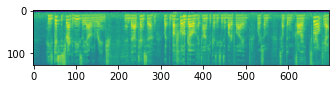

torch.Size([1, 128, 696])

<ipython-input-39-7572ec4b1c0b>:285: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor((queries - floor), dtype=grid_type, device=grid_device)


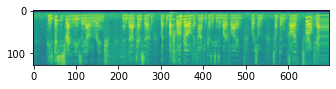

torch.Size([1, 128, 696])

In [41]:
def test_time_warp(spectro):
    tensor_to_img(time_warp(spectro))
tensor_to_img(spectrogram)    
test_time_warp(spectrogram)

## Frequency Masking

In [42]:
def freq_mask(spec, F=30, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    num_mel_channels = cloned.shape[1]
    
    for i in range(0, num_masks):        
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - f)

        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): return cloned

        mask_end = random.randrange(f_zero, f_zero + f) 
        if (replace_with_zero): cloned[0][f_zero:mask_end] = 0
        else: cloned[0][f_zero:mask_end] = cloned.mean()
    
    return cloned

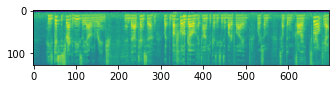

torch.Size([1, 128, 696])

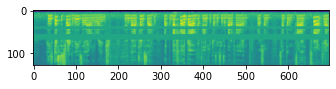

torch.Size([1, 128, 696])

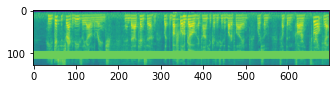

torch.Size([1, 128, 696])

In [48]:
def test_freq_mask(spectro):
    tensor_to_img(freq_mask(spectro))
    # Two Masks...
    tensor_to_img(freq_mask(spectro, num_masks=2))
    # with zeros
    tensor_to_img(freq_mask(spectro, num_masks=2, replace_with_zero=True))
test_freq_mask(spectrogram)

## Time Masking

In [44]:
def time_mask(spec, T=40, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    len_spectro = cloned.shape[2]
    
    for i in range(0, num_masks):
        t = random.randrange(0, T)
        t_zero = random.randrange(0, len_spectro - t)

        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t): return cloned

        mask_end = random.randrange(t_zero, t_zero + t)
        if (replace_with_zero): cloned[0][:,t_zero:mask_end] = 0
        else: cloned[0][:,t_zero:mask_end] = cloned.mean()
    return cloned

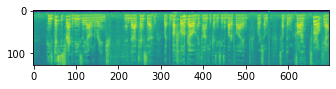

torch.Size([1, 128, 696])

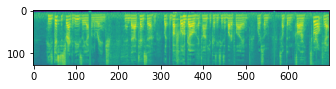

torch.Size([1, 128, 696])

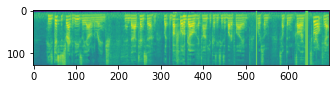

torch.Size([1, 128, 696])

In [49]:
def test_time_mask(spectro):
    tensor_to_img(time_mask(spectro))
    # Two Masks...
    tensor_to_img(time_mask(spectro, num_masks=2))
    # with zeros
    tensor_to_img(time_mask(spectro, num_masks=2, replace_with_zero=True))
test_time_mask(spectrogram)

## Full SpecAugment

<ipython-input-39-7572ec4b1c0b>:285: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor((queries - floor), dtype=grid_type, device=grid_device)


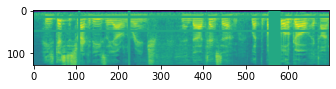

torch.Size([1, 128, 696])

In [53]:
combined = time_mask(freq_mask(time_warp(spectrogram), num_masks=4), num_masks=4)
tensor_to_img(combined)